In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [19]:
# Load results of the fitting procedure

subject = 1

# fitting_types = ['semantic_real_world_size']
# fitting_types = ['semantic_coco_things_supcateg']
# fitting_types = ['semantic_indoor_outdoor','semantic_animacy','semantic_natural_humanmade']
fitting_types = ['all_coco','all_coco_categ','all_coco_things', 'all_coco_stuff']
# fitting_types = ['semantic_animacy']
# fitting_types = ['semantic_discrim_raw','gabor_solo_ridge_12ori_8sf','sketch_tokens', 'alexnet_all_conv']
# fitting_types = ['semantic_animacy','semantic_indoor_outdoor','semantic_food','semantic_vehicle',\
#                  'semantic_person','semantic_animal', 'semantic_all_supcat']
# fitting_types = ['semantic_natural_humanmade']
# nf = [0,0,0,0,0,0,0,0,0]
nf = [0,0,0,0]
discrim = []
outlist = []
for fi, fitting_type in enumerate(fitting_types):
    out = load_fits.load_fit_results(subject,fitting_type,n_from_end=0,verbose=True);

    print(out['which_prf_grid'])
    print(out['up_to_sess'])
#     discrim.append(out['sem_discrim_each_axis'])
    outlist.append(out)
    
    
fig_save_folder=None

loading from /user_data/mmhender/imStat/model_fits/S01/all_coco/Feb-22-2022_1250_46/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'semantic_feature_set'])
5
40
loading from /user_data/mmhender/imStat/model_fits/S01/all_coco_categ/Feb-22-2022_1128_13/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'va

In [20]:
roi_def = roi_utils.nsd_roi_def(subject, verbose=False)

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,21, 23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]



/user_data/mmhender/imStat/code/plotting/summary_plots.py:51: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log');


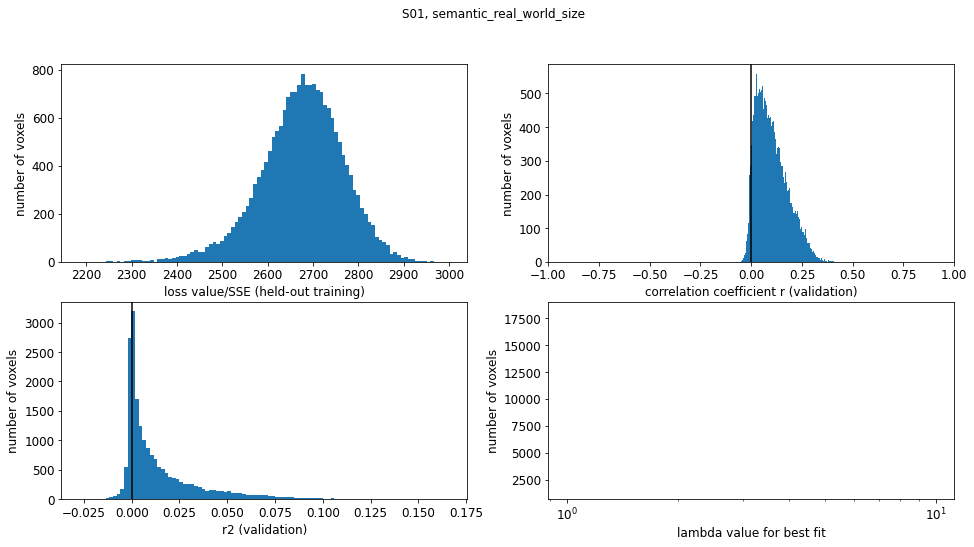

In [5]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(fitting_types[0], outlist[0], fig_save_folder=fig_save_folder)

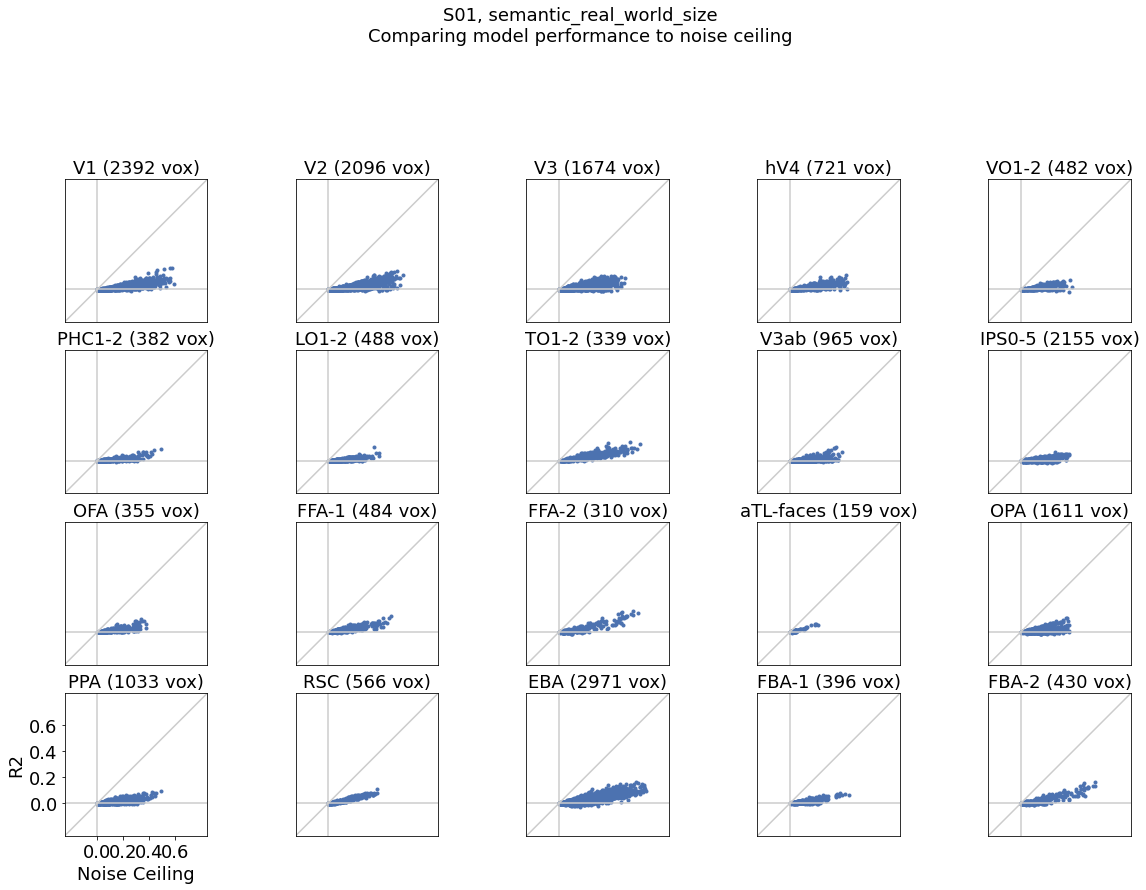

In [6]:
plot_utils.set_all_font_sizes(fs = 18)
for ii in range(len(fitting_types)):
    summary_plots.plot_r2_vs_nc(fitting_types[ii],outlist[ii], roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

In [16]:
# Make plots in pycortex for individual semantic model fits

import cortex

port=44442

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [9, 360, 9]

names += ['R2: %s'%ft for ft in fitting_types]
maps += [np.sqrt(outlist[ii]['val_r2'][:,0]) for ii in range(len(fitting_types))]
cmaps += ['PuBu' for ii in range(len(fitting_types))]
mins += [0 for ii in range(len(fitting_types))]
maxes += [0.60 for ii in range(len(fitting_types))]

# vox2plot = outlist[0]['val_r2'][:,0]>0.01
vox2plot = None
pycortex_plot_utils.plot_maps_pycortex(subject, port, maps=maps, names=names, roi_def=roi_def, \
                                       vox2plot=vox2plot, title=fitting_type,
                              cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:44442
Started server on port 44442


In [9]:
len(maps), len(names), len(cmaps), len(mins), len(maxes)

(6, 6, 6, 6, 6)

In [14]:
thing = (np.arange(50)>25).astype(int)
import scipy.stats
zthing = scipy.stats.zscore(thing)
zthing

array([-0.96076892, -0.96076892, -0.96076892, -0.96076892, -0.96076892,
       -0.96076892, -0.96076892, -0.96076892, -0.96076892, -0.96076892,
       -0.96076892, -0.96076892, -0.96076892, -0.96076892, -0.96076892,
       -0.96076892, -0.96076892, -0.96076892, -0.96076892, -0.96076892,
       -0.96076892, -0.96076892, -0.96076892, -0.96076892, -0.96076892,
       -0.96076892,  1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,
        1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,
        1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,
        1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,
        1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ,  1.040833  ])

In [15]:
thing = (np.arange(50)>5).astype(int)
import scipy.stats
zthing = scipy.stats.zscore(thing)
zthing

array([-2.7080128 , -2.7080128 , -2.7080128 , -2.7080128 , -2.7080128 ,
       -2.7080128 ,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447,
        0.36927447,  0.36927447,  0.36927447,  0.36927447,  0.36927447])

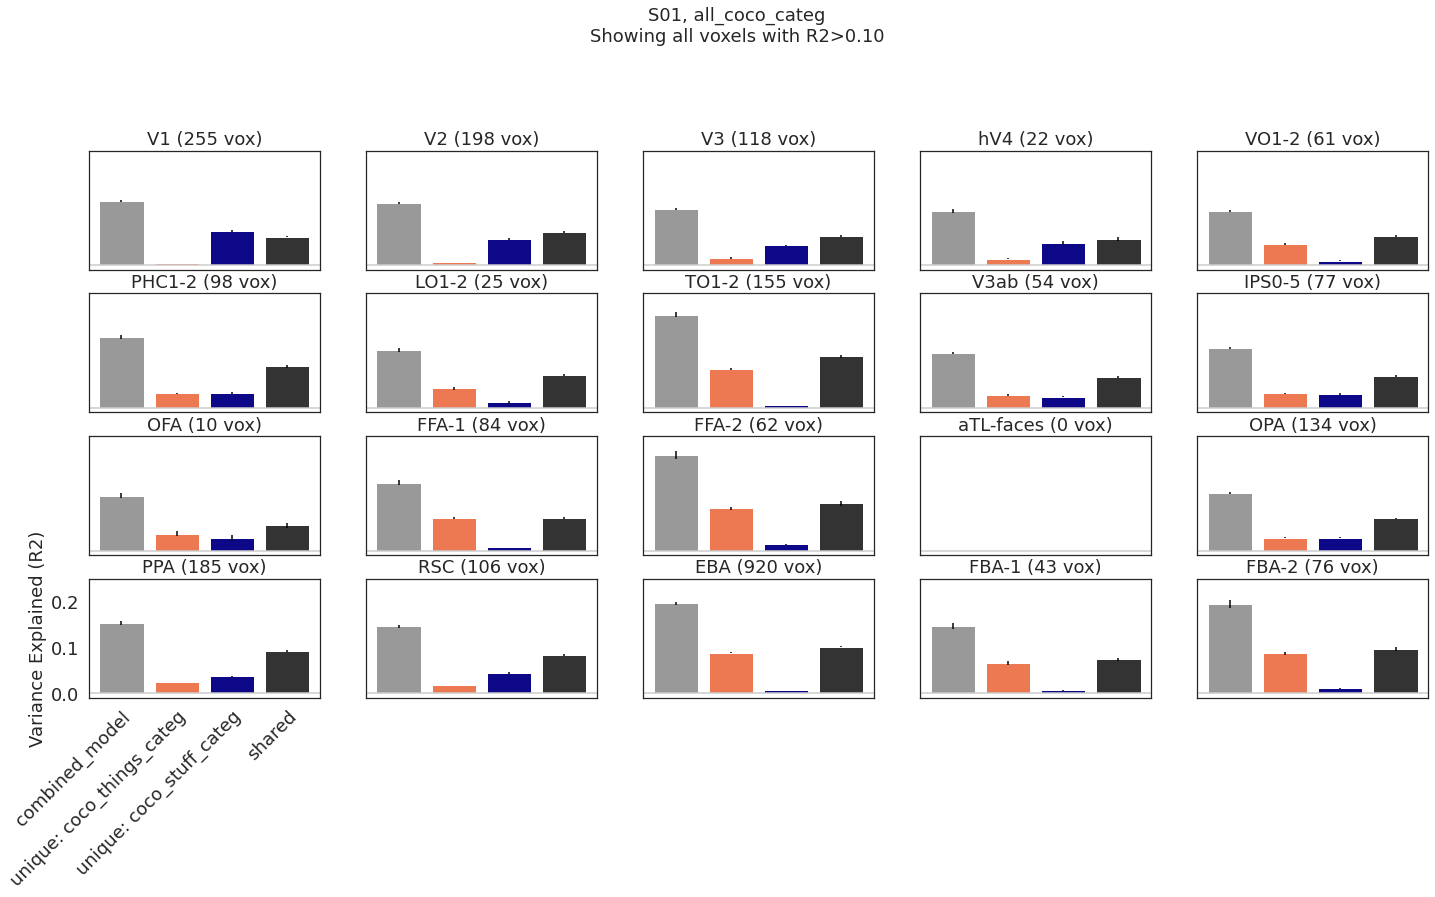

In [58]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1].split('just_semantic_')[1]
name2 = out['partial_version_names'][pp2].split('just_semantic_')[1]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

r2_thresh = 0.10;
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.25])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, \
                               skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.png'))

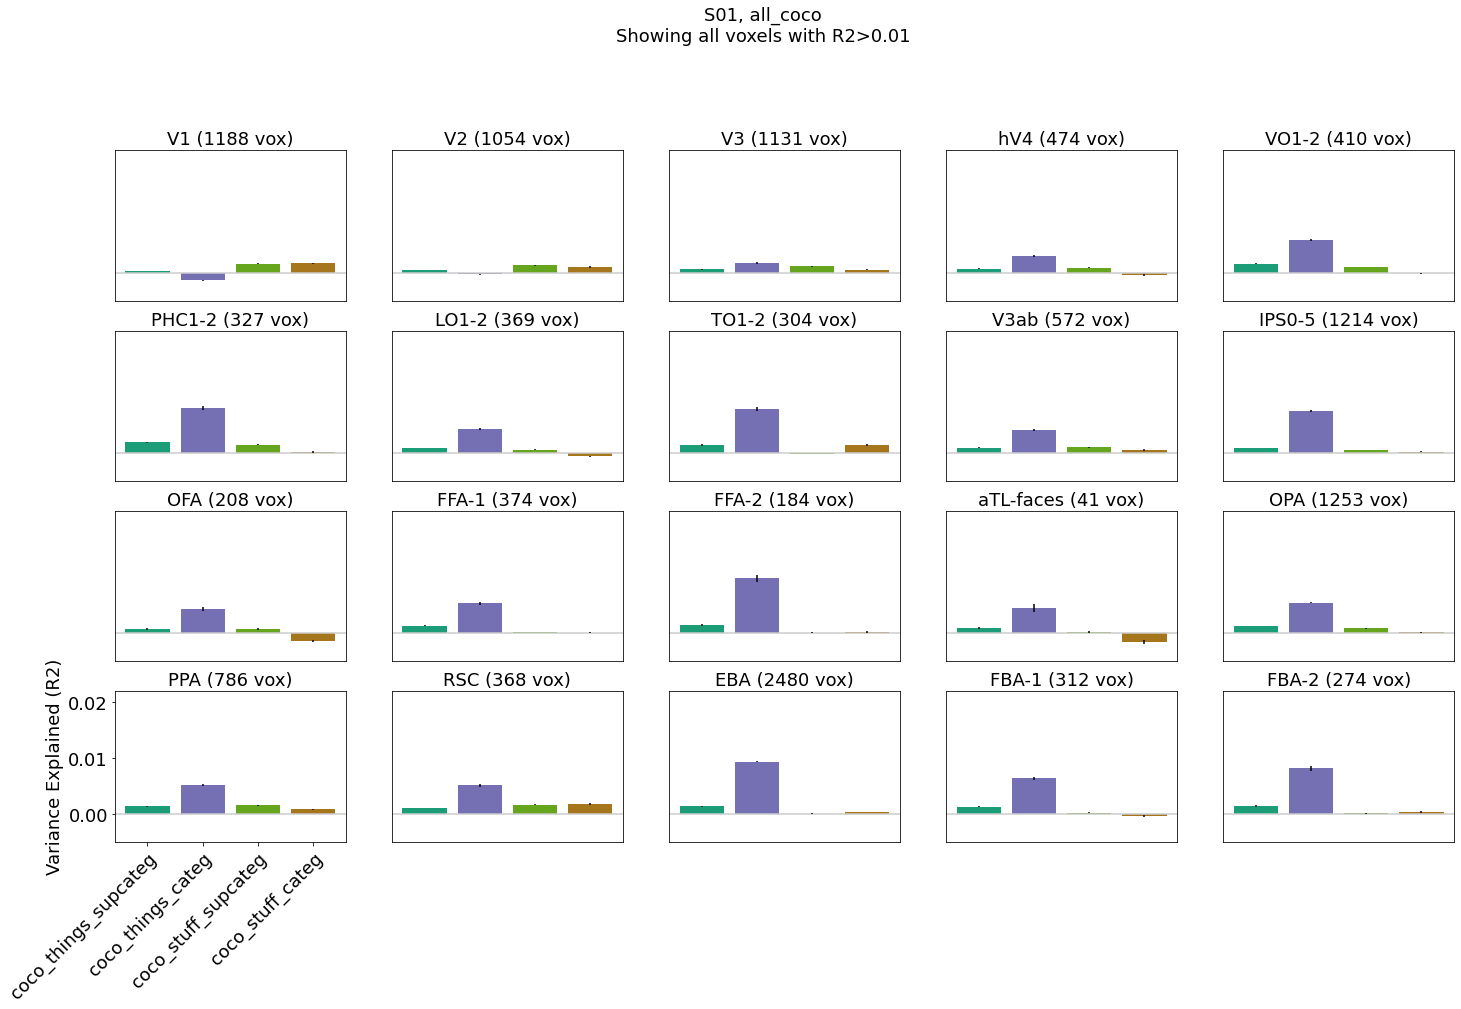

In [15]:
ppinds = [2,4,6,8]

ve_names = [out['partial_version_names'][pp].split('leave_out_semantic_')[1] for pp in ppinds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,4]) - out['val_r2'][:,ppinds]

colors = cm.Dark2(np.linspace(0,1,5))
# colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.005, 0.022])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


In [29]:
out['partial_version_names']

['full_combined_model',
 'just_semantic_coco_things_supcateg',
 'leave_out_semantic_coco_things_supcateg',
 'just_semantic_coco_things_categ',
 'leave_out_semantic_coco_things_categ',
 'just_semantic_coco_stuff_supcateg',
 'leave_out_semantic_coco_stuff_supcateg',
 'just_semantic_coco_stuff_categ',
 'leave_out_semantic_coco_stuff_categ']

In [4]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=13333

vox2plot = out['val_r2'][:,0]>0

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 concat']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(out['val_r2'][:,0])]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [9, 360, 9, 0.8]


ppinds = [1,3,5,7]

names += ['R2: %s alone'%out['partial_version_names'][pp].split('just_semantic_')[1] for pp in ppinds]
maps += [np.sqrt(out['val_r2'][:,pp]) for pp in ppinds]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0]
maxes += [0.80, 0.80, 0.80, 0.80]

ppinds = [2,4,6,8]
ve_names = [out['partial_version_names'][pp].split('leave_out_semantic_')[1] for pp in ppinds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,4]) - out['val_r2'][:,ppinds]
max_ind = np.argmax(var_expl, axis=1).astype(np.float32)

maps += [max_ind+1] + [np.sqrt(var_expl[:,fi]) for fi in range(var_expl.shape[1])]
names += ['Prefered feature type (based on unique var)'] + ve_names
cmaps += ['plasma_r', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [4, 0.20, 0.20, 0.20, 0.20]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot,\
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [21]:
np.any(np.isnan(vox2plot))

False